<a href="https://colab.research.google.com/github/stuartluxe/StockPredictionAi/blob/main/Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [136]:
pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [137]:
pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [138]:
from utils import *
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from pandas_datareader import data as web
from matplotlib import pyplot as pp

import math
import xgboost as xgb
import pandas as pd   
import time
import numpy as np
import mxnet as mx
import datetime
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [139]:
import warnings
warnings.filterwarnings("ignore")

In [140]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(42)

In [141]:
# Create data framework

In [142]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [143]:
dataset_ex_df = pd.read_csv('drive/MyDrive/Colab Notebooks/data/GS.csv', header=0, parse_dates=[0], date_parser=parser)

In [144]:
dataset_ex_df[['Date', 'Close']].head(3)

,Date,Close
0,2017-01-03,241.570007
1,2017-01-04,243.130005
2,2017-01-05,241.320007


In [145]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 1259 number of days in the dataset.


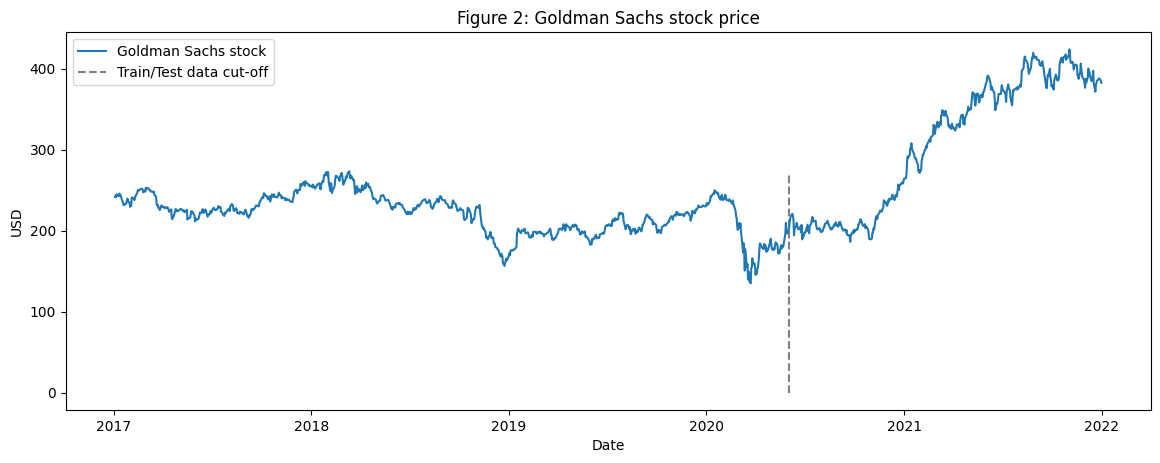

In [146]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Goldman Sachs stock')
plt.vlines(datetime.date(2020,6, 1), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

In [147]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 881. Number of test days: 378.


In [148]:
# Create technical indicators

In [149]:
def get_technical_indicators(dataset):
    # Create 20 and 200 day Moving Average
    dataset['ma20'] = dataset['Close'].rolling(min_periods=1, window=20).mean()
    dataset['ma200'] = dataset['Close'].rolling(min_periods=1, window=200).mean()
    
    return dataset

In [150]:
data_TI = get_technical_indicators(dataset_ex_df[['Close']])

In [151]:
data_TI.head()

,Close,ma20,ma200
0,241.570007,241.570007,241.570007
1,243.130005,242.350006,242.350006
2,241.320007,242.006673,242.006673
3,244.899994,242.730003,242.730003
4,242.889999,242.762002,242.762002


In [152]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma20'],label='MA 20', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma200'],label='MA 200', color='r',linestyle='--')
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.xlabel('Days')
    plt.legend()
    plt.show()

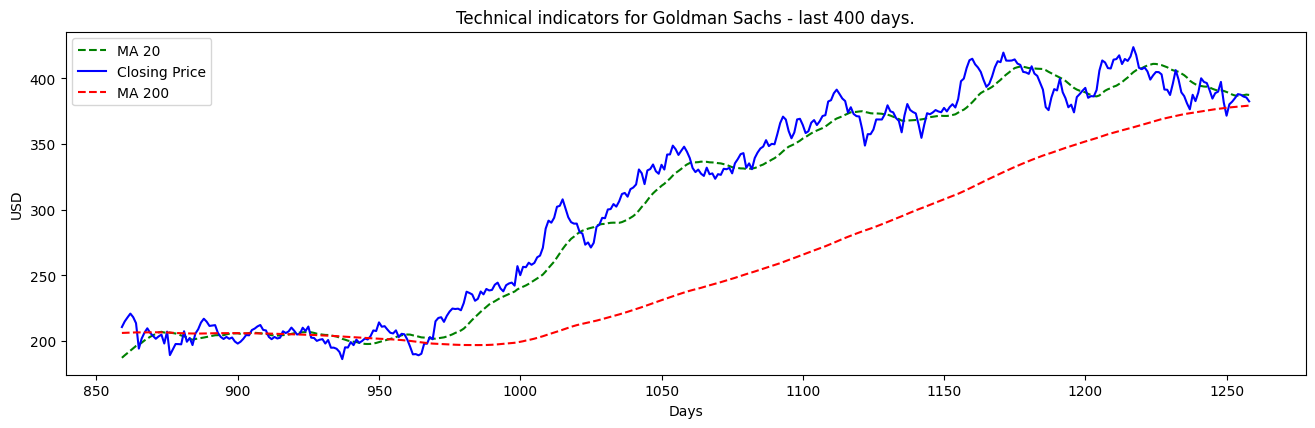

In [153]:
plot_technical_indicators(data_TI, 400)

In [154]:
# Create ARIMA model

In [155]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_TI['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1258
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3655.111
Method:                       css-mle   S.D. of innovations              4.422
Date:                Sat, 19 Nov 2022   AIC                           7324.221
Time:                        07:09:25   BIC                           7360.182
Sample:                             1   HQIC                          7337.736
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1123      0.113      0.993      0.321      -0.109       0.334
ar.L1.D.Close    -0.0388      0.028     -1.377      0.168      -0.094       0.016
ar.L2.D.Close     0.0621      0.028     

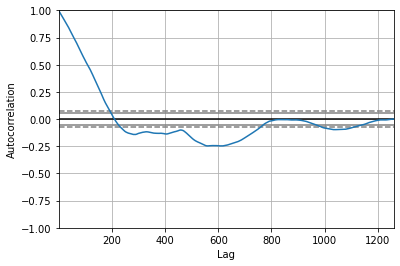

<Figure size 800x560 with 0 Axes>

In [156]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [157]:
# Mean squared error
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
ARIMA_predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    ARIMA_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [158]:
error = mean_squared_error(test, ARIMA_predictions)
print('Test MSE: %.3f' % error)

Test MSE: 27.069


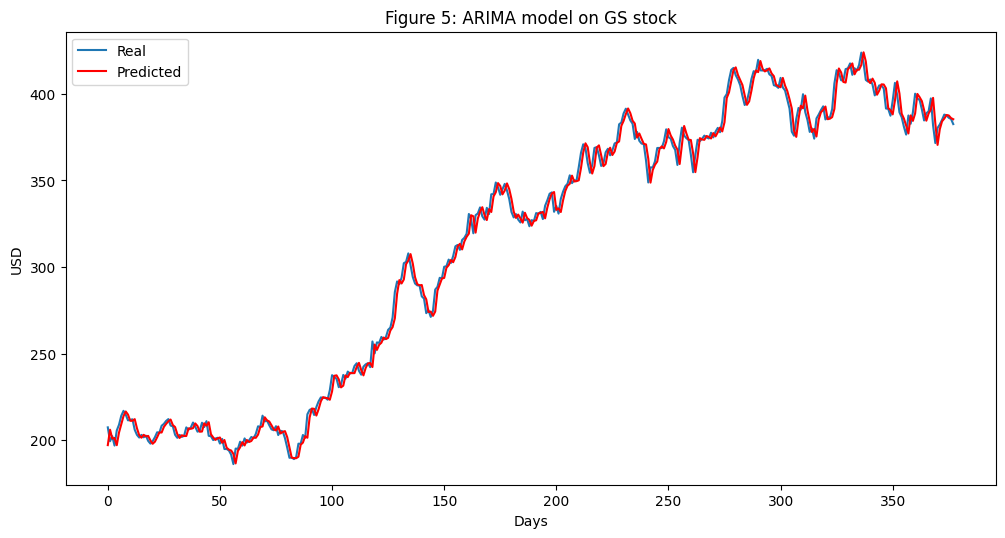

In [159]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(ARIMA_predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

In [160]:
# Convert array into dataframe
data_A = pd.DataFrame(ARIMA_predictions)
data_A.columns = ['arima']

In [161]:
# Create LSTM model

In [162]:
!pip install tensorflow==2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [163]:
zscore = lambda x:(x -x.mean())/x.std() # zscore: normalization of log returns

In [164]:
# Correlated asset

In [165]:
# We select MS because it has the highest correlation to GS from https://www.stockcorrelation.net/
start = dt.datetime(2017,1,1)
end = dt.datetime(2022,1,1)
data_LSTM = web.DataReader("MS", "yahoo", start, end)

In [166]:
def _load_data(data, n_prev):  
    
    # Data in pd.DataFrame()
    docX, docY = [], []
    for i in range(len(data)-n_prev):
        zscore(data.iloc[i:i+n_prev+1])
        docX.append(zscore(data.iloc[i:i+n_prev]).to_numpy())
        docY.append(zscore(data.iloc[i:i+n_prev+1]).Close[30])
    alsX = np.array(docX)
    alsY = np.array(docY)
    
    return alsX, alsY

In [167]:
def train_test_split(data_LSTM, test_size=0.3):  
    
    # Splits data into train and test
    ntrn = int(round(len(data_LSTM) * (1 - test_size)))

    X_train, y_train = _load_data(data_LSTM.iloc[0:ntrn],30)
    X_test, y_test = _load_data(data_LSTM.iloc[ntrn:],30)

    return (X_train, y_train), (X_test, y_test)

In [168]:
(X_train, y_train), (X_test, y_test) = train_test_split(data_LSTM)

In [169]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout 
from keras.layers import LSTM


hidden_neurons = 300

model = Sequential()
model.add(LSTM(300, input_shape=(30, 6), return_sequences=False))       
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("tanh"))

model.compile(loss="mean_squared_error", optimizer="Adam",  metrics=['accuracy'])  

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 300)               368400    
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 301       
                                                                 
 activation_2 (Activation)   (None, 1)                 0         
                                                                 
Total params: 368,701
Trainable params: 368,701
Non-trainable params: 0
_________________________________________________________________


In [170]:
model.fit(X_train, y_train, batch_size=500, epochs=500, validation_split=0.05)  

Epoch 1/500
2/2 [==============================] - 2s 583ms/step - loss: 1.4629 - accuracy: 0.0000e+00 - val_loss: 1.1120 - val_accuracy: 0.0000e+00
Epoch 2/500
2/2 [==============================] - 0s 42ms/step - loss: 1.0388 - accuracy: 0.0000e+00 - val_loss: 0.9748 - val_accuracy: 0.0000e+00
Epoch 3/500
2/2 [==============================] - 0s 42ms/step - loss: 0.8909 - accuracy: 0.0000e+00 - val_loss: 0.9183 - val_accuracy: 0.0000e+00
Epoch 4/500
2/2 [==============================] - 0s 41ms/step - loss: 0.7816 - accuracy: 0.0000e+00 - val_loss: 0.9106 - val_accuracy: 0.0000e+00
Epoch 5/500
2/2 [==============================] - 0s 40ms/step - loss: 0.7253 - accuracy: 0.0000e+00 - val_loss: 0.9281 - val_accuracy: 0.0000e+00
Epoch 6/500
2/2 [==============================] - 0s 37ms/step - loss: 0.7081 - accuracy: 0.0000e+00 - val_loss: 0.9136 - val_accuracy: 0.0000e+00
Epoch 7/500
2/2 [==============================] - 0s 35ms/step - loss: 0.6751 - accuracy: 0.0000e+00 - val_los

In [171]:
predicted = model.predict(X_test) 

In [172]:
outcome = pd.DataFrame()
outcome['actual'] = y_test
outcome['predicted'] = predicted
data_LSTM = outcome

In [173]:
metrics = model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 4ms/step - loss: 0.7900 - accuracy: 0.0000e+00


In [174]:
data_LSTM

,actual,predicted
0,0.573963,0.993466
1,0.278825,0.987998
2,0.558329,0.871491
3,0.065654,0.673550
4,0.245286,0.679666
...,...,...
343,0.851336,0.070515
344,0.601217,0.994453
345,-0.032590,0.999433
346,0.028778,0.991692


In [175]:
data_TI

,Close,ma20,ma200
0,241.570007,241.570007,241.570007
1,243.130005,242.350006,242.350006
2,241.320007,242.006673,242.006673
3,244.899994,242.730003,242.730003
4,242.889999,242.762002,242.762002
...,...,...,...
1254,388.040009,386.922000,378.498650
1255,387.609985,386.975499,378.706450
1256,386.200012,387.236000,378.928900
1257,385.519989,387.687999,379.131750


In [176]:
data_A

,arima
0,197.101584
1,205.995614
2,200.846021
3,201.248695
4,197.046839
...,...
373,385.729880
374,387.807905
375,387.522017
376,386.017792


In [177]:
# Feature engineering

In [178]:
frames = [data_TI, data_A, data_LSTM]
dataset_total_df = pd.concat(frames).groupby(level=0).mean()
dataset_total_df.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset_total_df.dropna()

,Close,ma20,ma200,arima,actual,predicted
0,241.570007,241.570007,241.570007,197.101584,0.573963,0.993466
1,243.130005,242.350006,242.350006,205.995614,0.278825,0.987998
2,241.320007,242.006673,242.006673,200.846021,0.558329,0.871491
3,244.899994,242.730003,242.730003,201.248695,0.065654,0.673550
4,242.889999,242.762002,242.762002,197.046839,0.245286,0.679666
...,...,...,...,...,...,...
343,241.559998,241.678500,245.754750,399.520608,0.851336,0.070515
344,240.960007,241.026501,245.832900,401.916097,0.601217,0.994453
345,239.100006,240.273001,245.893400,405.515696,-0.032590,0.999433
346,237.000000,239.525001,245.947050,405.412090,0.028778,0.991692


In [179]:
dataset_total_df

,Close,ma20,ma200,arima,actual,predicted
0,241.570007,241.570007,241.570007,197.101584,0.573963,0.993466
1,243.130005,242.350006,242.350006,205.995614,0.278825,0.987998
2,241.320007,242.006673,242.006673,200.846021,0.558329,0.871491
3,244.899994,242.730003,242.730003,201.248695,0.065654,0.673550
4,242.889999,242.762002,242.762002,197.046839,0.245286,0.679666
...,...,...,...,...,...,...
1254,388.040009,386.922000,378.498650,NaN,NaN,NaN
1255,387.609985,386.975499,378.706450,NaN,NaN,NaN
1256,386.200012,387.236000,378.928900,NaN,NaN,NaN
1257,385.519989,387.687999,379.131750,NaN,NaN,NaN


In [180]:
print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], \
                                                              dataset_total_df.shape[1]))

Total dataset has 1259 samples, and 6 features.


In [181]:
# Create XGBoost feature importance

In [182]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.70)
 
    X_train_FI = X.iloc[:train_samples]
    X_test_FI = X.iloc[train_samples:]

    y_train_FI = y.iloc[:train_samples]
    y_test_FI = y.iloc[train_samples:]
    
    return (X_train_FI, y_train_FI), (X_test_FI, y_test_FI)

In [183]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_total_df)

In [184]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [185]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

[07:12:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [186]:
eval_result = regressor.evals_result()

In [187]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

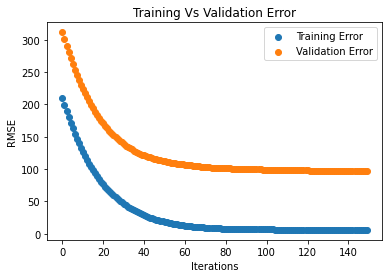

In [188]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

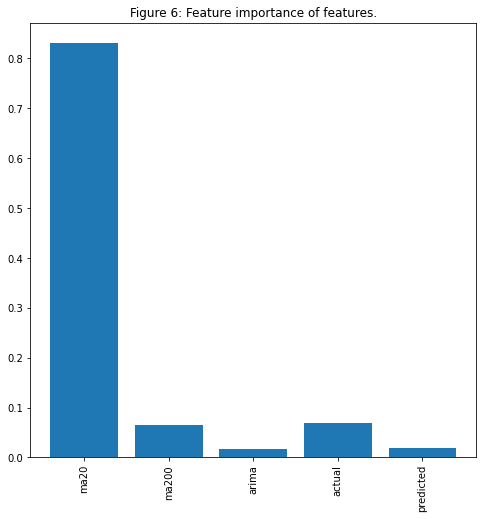

In [189]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of features.')
plt.show()

In [190]:
# Create GAN 

In [191]:
# Installing Tabgan
CMD = "wget https://raw.githubusercontent.com/Diyago/"\
  "GAN-for-tabular-data/master/requirements.txt"

!{CMD}
!pip install -r requirements.txt
!pip install tabgan

--2022-11-19 07:12:01--  https://raw.githubusercontent.com/Diyago/GAN-for-tabular-data/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184 [text/plain]
Saving to: ‘requirements.txt.4’

requirements.txt.4  100%[===================>]     184  --.-KB/s    in 0s      

2022-11-19 07:12:01 (8.51 MB/s) - ‘requirements.txt.4’ saved [184/184]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl (26.1 MB)
  Using cached category_encoders-2.1.0-py2.py3-none-any.whl (100 kB)
ERROR: Could not find a version that satisfies the requirement numpy==1.22.0 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0

In [192]:
# Train NN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import io
import os
import requests
import numpy as np
from sklearn import metrics

"""
# Use other files
df = pd.read_csv("drive/MyDrive/Colab Notebooks/data/GS.csv", na_values=['NA', '?'])
COLS_USED = ['Close']
df = df[COLS_USED]
"""

# Set df = total dataset
df = dataset_total_df, na_values=['NA', '?']

# Split into training and test sets
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
    df.drop("Close", axis=1),
    df["Close"],
    test_size=0.30,
    #shuffle=False,
    random_state=42,
)

# Create dataframe versions for tabular GAN
df_x_test, df_y_test = df_x_test.reset_index(drop=True), \
  df_y_test.reset_index(drop=True)
df_y_train = pd.DataFrame(df_y_train)
df_y_test = pd.DataFrame(df_y_test)

# Pandas to Numpy
x_train = df_x_train.values
x_test = df_x_test.values
y_train = df_y_train.values
y_test = df_y_test.values

# Build the neural network
model = Sequential()
# Hidden 1
model.add(Dense(50, input_dim=x_train.shape[1], activation='relu')) 
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(12, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),
        callbacks=[monitor], verbose=2,epochs=1000)

Epoch 1/1000
28/28 - 1s - loss: 65984.1719 - val_loss: 65508.9727 - 545ms/epoch - 19ms/step
Epoch 2/1000
28/28 - 0s - loss: 65970.2734 - val_loss: 65495.1445 - 135ms/epoch - 5ms/step
Epoch 3/1000
28/28 - 0s - loss: 65956.3594 - val_loss: 65481.2539 - 136ms/epoch - 5ms/step
Epoch 4/1000
28/28 - 0s - loss: 65942.4219 - val_loss: 65467.4336 - 123ms/epoch - 4ms/step
Epoch 5/1000
28/28 - 0s - loss: 65928.5156 - val_loss: 65453.5664 - 133ms/epoch - 5ms/step
Epoch 6/1000
28/28 - 0s - loss: 65914.6250 - val_loss: 65439.5977 - 165ms/epoch - 6ms/step
Epoch 7/1000
28/28 - 0s - loss: 65900.6797 - val_loss: 65425.8008 - 230ms/epoch - 8ms/step
Epoch 8/1000
28/28 - 0s - loss: 65886.7812 - val_loss: 65411.9648 - 127ms/epoch - 5ms/step
Epoch 9/1000
28/28 - 0s - loss: 65872.8906 - val_loss: 65398.0703 - 104ms/epoch - 4ms/step
Epoch 10/1000
28/28 - 0s - loss: 65858.9688 - val_loss: 65384.2422 - 89ms/epoch - 3ms/step
Epoch 11/1000
28/28 - 0s - loss: 65845.1016 - val_loss: 65370.4062 - 89ms/epoch - 3ms/ste

In [193]:
# Predict
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 229.1091627319767


In [194]:
# Train GAN
from tabgan.sampler import GANGenerator
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

gen_x, gen_y = GANGenerator(gen_x_times=1.1, cat_cols=None,
           bot_filter_quantile=0.001, top_filter_quantile=0.999, \
              is_post_process=True,
           adversarial_model_params={
               "metrics": "rmse", "max_depth": 2, "max_bin": 100, 
               "learning_rate": 0.02, "random_state": \
                42, "n_estimators": 500,
           }, pregeneration_frac=2, only_generated_data=False,\
           gan_params = {"batch_size": 500, "patience": 25, \
          "epochs" : 500,}).generate_data_pipe(df_x_train, df_y_train,\
          df_x_test, deep_copy=True, only_adversarial=False, \
          use_adversarial=True)

          # Restart runtime if ContextualVersionConflict 

Fitting CTGAN transformers for each column:   0%|          | 0/1 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

In [195]:
gen_x

""
0
1
2
3
4
...
2814
2815
2816
2817


In [196]:
gen_y

0       227.990005
1       276.377245
2       263.447557
3       253.720298
4       247.631994
           ...    
2814    194.505025
2815    350.723892
2816    205.640605
2817    387.044778
2818    241.261870
Name: Close, Length: 2819, dtype: float64

In [197]:
# Predict
pred = model.predict(gen_x.values)
score = np.sqrt(metrics.mean_squared_error(pred,gen_y.values))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 219.6273819961242


In [198]:
# Update value to last index value
print(dataset_ex_df['Close'].loc[[1258]])

1258    382.549988
Name: Close, dtype: float64


In [199]:
# Prediction accuracy
df_close = dataset_ex_df
Normalized_RMSE = score / (df_close['Close'].max() - df_close['Close'].min())
Normalized_RMSE

0.7602720098129471